In [10]:
import pandas as pd

rankings_file = 'C:/Users/LP5/NLP/data/raw/boardgames_ranks_2024-08-13/boardgames_ranks.csv'  # Adjust the path as needed
df_rankings = pd.read_csv(rankings_file)

# Extracting the top 10 games based on rank (assuming there's a 'rank' column)
top_games = df_rankings.sort_values(by='rank').head(10)


print("Top 10 Games:")
print(top_games)



Top 10 Games:
            id                                    name  yearpublished  rank  \
78536   144585               La pesadilla de mi abuelo           2013     0   
104712  249709                         Going Hollywood           1941     0   
104713  249710            Munchkin: The Red Dragon Inn           2018     0   
104714  249732                      Masters of Gettown           2018     0   
104715  249735                      Solo Sonderedition           2018     0   
104716  249741  Golden Trivia Cards: Star Trek Edition           1985     0   
104717  249743                               Terria 2K           2018     0   
104718  249744                                  Gaburu           2018     0   
104719  249745                      Gaslands: Wipe Out           2018     0   
104720  249749                                  WORDOS           2019     0   

        bayesaverage  average  usersrated  is_expansion  abstracts_rank  \
78536            0.0  0.00000           0

In [14]:
top_games.to_csv('C:/Users/LP5/NLP/data/processed/top_games.csv', index=False)  # Save the top games to a CSV file


Loading Model

In [1]:
!pip install huggingface_hub


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
# Load the saved model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('D:/NLP/scripts/distilbert-imdb')


model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [6]:
!pip install langdetect


     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     --------- ---------------------------- 245.8/981.5 kB 5.1 MB/s eta 0:00:01
     --------------------- ---------------- 553.0/981.5 kB 5.8 MB/s eta 0:00:01
     ------------------------ ------------- 645.1/981.5 kB 5.8 MB/s eta 0:00:01
     ------------------------------------ - 942.1/981.5 kB 5.0 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993254 sha256=12f75c19f60e6c38a0aecbf43480c098d509ef3ea08c827f95803875a0dfae3f
  Stored in directory: c:\users\lp5\appdata\local\pip\cache\wheels\0a\f2\b2\e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

comments_df = pd.read_csv('D:/NLP/data/raw/boardgames_comments.csv')

# function to detect and filter out only English comments
def is_english(comment):
    try:
        return detect(comment) == 'en'
    except:
        return False


comments_df['is_english'] = comments_df['value'].apply(is_english)
english_comments_df = comments_df[comments_df['is_english'] == True]


english_comments_df.to_csv('english_comments_bgg.csv', index=False)


english_comments_df = english_comments_df.drop(columns=['is_english'])




In [10]:
from transformers import DistilBertTokenizer

# Loading the pre-trained tokenizer directly from Hugging Face
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [1]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Loading the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('D:/NLP/scripts/distilbert-imdb')










c:\Users\LP5\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comments_df = pd.read_csv('D:/NLP/data/processed/english_comments_bgg.csv')

# function to tokenize comments
def tokenize_function(examples):
    return tokenizer(examples, truncation=True, padding='max_length', max_length=128)

# Tokenize the BGG comments
comments_df['tokenized'] = comments_df['value'].apply(tokenize_function)

comments_df['input_ids'] = comments_df['tokenized'].apply(lambda x: x['input_ids'])
comments_df['attention_mask'] = comments_df['tokenized'].apply(lambda x: x['attention_mask'])


input_ids = torch.tensor(comments_df['input_ids'].tolist())
attention_mask = torch.tensor(comments_df['attention_mask'].tolist())


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move input tensors to the same device as the model
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  

batch_size = 16

# Convert tokenized comments into torch tensors
input_ids = torch.tensor([token['input_ids'] for token in comments_df['tokenized']])
attention_mask = torch.tensor([token['attention_mask'] for token in comments_df['tokenized']])

dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)


all_predictions = []

model.eval()  
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_input_ids, batch_attention_mask = batch
        
    
        batch_input_ids = batch_input_ids.to('cuda' if torch.cuda.is_available() else 'cpu')
        batch_attention_mask = batch_attention_mask.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        
      
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1)
   
        all_predictions.extend(batch_predictions.cpu().numpy())

comments_df['predictions'] = all_predictions

# Save the DataFrame with predictions
comments_df.to_csv('D:/NLP/data/processed/bgg_comments_with_predictions.csv', index=False)

print("Inference completed and results saved!")



100%|██████████| 3194/3194 [1:28:48<00:00,  1.67s/it]


Inference completed and results saved!


In [5]:
!pip install vaderSentiment


   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   --- ------------------------------------ 10.2/126.0 kB ? eta -:--:--
   --- ------------------------------------ 10.2/126.0 kB ? eta -:--:--
   --------- ----------------------------- 30.7/126.0 kB 325.1 kB/s eta 0:00:01
   ------------------- ------------------- 61.4/126.0 kB 409.6 kB/s eta 0:00:01
   -------------------------------------  122.9/126.0 kB 654.9 kB/s eta 0:00:01
   -------------------------------------- 126.0/126.0 kB 570.0 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

comments_df = pd.read_csv('D:/NLP/data/processed/bgg_comments_with_predictions.csv')

# Initializing VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment labels using VADER (only 2 classes: Positive and Negative)
def vader_sentiment_pseudo_label(comment):
    score = analyzer.polarity_scores(comment)
    if score['compound'] >= 0.05:
        return 1  # Positive
    else:
        return 0  # Negative


# pseudo labels using VADER
comments_df['pseudo_labels'] = comments_df['value'].apply(vader_sentiment_pseudo_label)

# Geting predictions from your model (already computed)
predictions = comments_df['predictions']

# Geting pseudo labels generated by VADER
pseudo_labels = comments_df['pseudo_labels']

# Calculate evaluation metrics
accuracy = accuracy_score(pseudo_labels, predictions)
precision = precision_score(pseudo_labels, predictions, average='weighted')
recall = recall_score(pseudo_labels, predictions, average='weighted')
f1 = f1_score(pseudo_labels, predictions, average='weighted')


print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# confusion matrix and classification report
print('\nClassification Report:\n', classification_report(pseudo_labels, predictions))

# Save evaluation results to a text file (optional)
with open('D:/NLP/data/processed/evaluation_results.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy:.4f}\n')
    f.write(f'Precision: {precision:.4f}\n')
    f.write(f'Recall: {recall:.4f}\n')
    f.write(f'F1 Score: {f1:.4f}\n')


Accuracy: 0.7291
Precision: 0.7439
Recall: 0.7291
F1 Score: 0.7351

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.59      0.54     14028
           1       0.83      0.78      0.81     37066

    accuracy                           0.73     51094
   macro avg       0.67      0.69      0.68     51094
weighted avg       0.74      0.73      0.74     51094



In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split


data = comments_df


aspects_with_synonyms = {
    'LUCK': ['fortune', 'chance', 'fate', 'destiny'],
    'BOOKKEEPING': ['accounting', 'record-keeping', 'financial management'],
    'DOWNTIME': ['break', 'pause', 'idle time'],
    'INTERACTION': ['engagement', 'communication', 'contact'],
    'BASH THE LEADER': ['criticize', 'attack', 'denounce'],
    'COMPLICATED': ['complex', 'intricate', 'confusing', 'difficult'],
    'COMPLEX': ['complicated', 'sophisticated', 'elaborate', 'involved']
}

# Function to extract aspects
def extract_aspects(comment, aspects_dict):
    found_aspects = []
    for aspect, synonyms in aspects_dict.items():
        # Check if aspect or any of its synonyms is in the comment
        if aspect.lower() in comment.lower() or any(syn.lower() in comment.lower() for syn in synonyms):
            found_aspects.append(aspect)
    return found_aspects

data['Extracted_Aspects'] = data['value'].apply(lambda x: extract_aspects(x, aspects_with_synonyms))

# Drop rows with NaN in 'Extracted_Aspects'
data = data.dropna(subset=['Extracted_Aspects'])

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


print("Training Data:\n", train_data)
print("Testing Data:\n", test_data)


Training Data:
        Unnamed: 0       username  rating  \
23094        5335         Tikron     9.5   
42639        2131      maras2002     8.0   
21149        2636      Jmarkmoss     7.0   
4851          532           Ax0r     9.0   
12181        1838   Cpscblackout    10.0   
...           ...            ...     ...   
11284         710         bagrar     7.0   
44732        1231     DrStranger     9.0   
38158       10242  PrimogenGames     6.0   
860          1278    danperrault     6.5   
15795        6437      mmasloski     NaN   

                                                   value  boardgame_id  \
23094  Tableau building for 2-4 players. Each player ...        342942   
42639      Seems to be complex but this is what I like!         115746   
21149  One play, need more!! 01/10/23  3 plays, reall...        342942   
4851                      Completed, harvested for parts        161936   
12181  Obviously deserving of its #1 spot, Gloomhaven...        174430   
...        

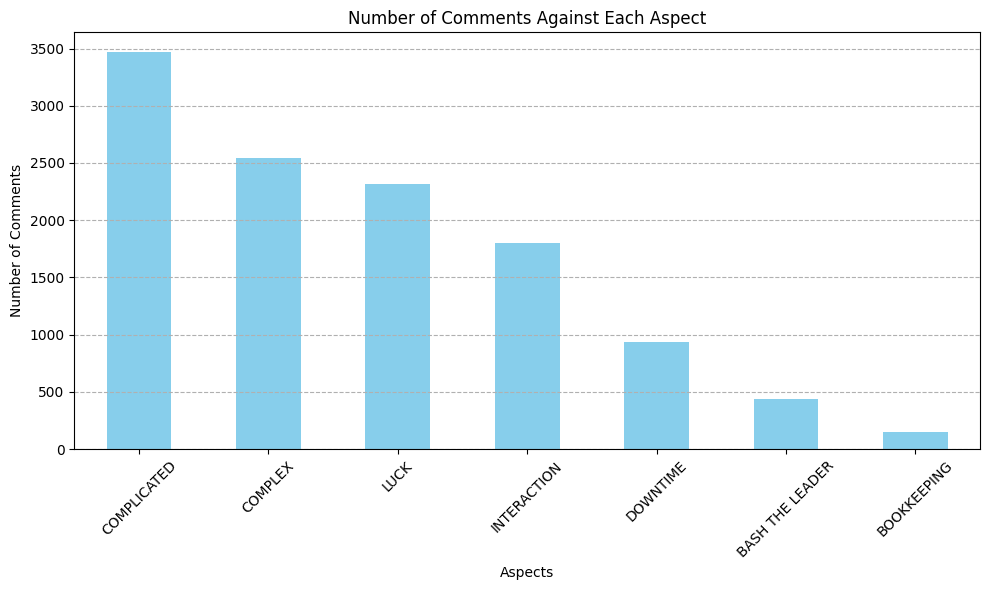

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of each aspect
aspect_counts = data['Extracted_Aspects'].explode().value_counts()

# Plotting
plt.figure(figsize=(10, 6))
aspect_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Comments Against Each Aspect')
plt.xlabel('Aspects')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


In [5]:
# Function to get sentiment for each comment and its aspects
def get_aspect_sentiment(comment_inputs, aspect):
    # Perform inference with the DistilBERT model
    with torch.no_grad():
        outputs = model(input_ids=comment_inputs['input_ids'], attention_mask=comment_inputs['attention_mask'])
        sentiment = torch.argmax(outputs.logits, dim=1).item()
        return "positive" if sentiment == 1 else "negative"


aspect_sentiments = []
for idx, row in comments_df.iterrows():
    comment_inputs = {
        'input_ids': input_ids[idx].unsqueeze(0),  # Prepare batch of size 1 for each comment
        'attention_mask': attention_mask[idx].unsqueeze(0)
    }
    sentiments = {aspect: get_aspect_sentiment(comment_inputs, aspect) for aspect in row['Extracted_Aspects']}
    aspect_sentiments.append(sentiments)


comments_df['Aspect_Sentiments'] = aspect_sentiments

print(comments_df[['value', 'Extracted_Aspects', 'Aspect_Sentiments']])


                                                   value  Extracted_Aspects  \
0      SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...                 []   
1      Great game, full controllo of your strategy th...                 []   
2                                          Location: MSK                 []   
3      Very clever game, enjoyable overall.  Plus poi...   [LUCK, DOWNTIME]   
4      Brilliant!  Fits right into my wheelhouse all ...      [INTERACTION]   
...                                                  ...                ...   
51089                       Nice for young / new players                 []   
51090  Only played the beginning scenarios with my el...                 []   
51091            Cooperative Legacy (2P-3P) ✓ Completion                 []   
51092  Too hard under the rules in the game and a bit...  [BASH THE LEADER]   
51093                              Fiddly and repetitive                 []   

                                  Aspect_Sentiments

In [6]:
comments_df[['value', 'Extracted_Aspects', 'Aspect_Sentiments']].to_csv('comments_with_aspect_sentiments.csv', index=False)


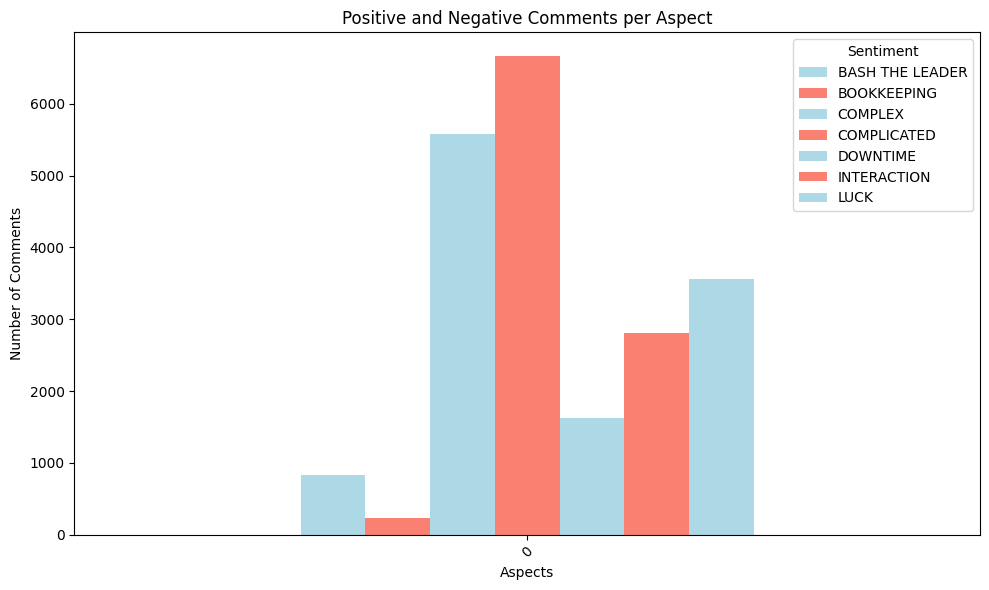

In [9]:
sentiment_counts = aspect_sentiment_flat.groupby(['Aspect', 'Sentiment']).size().unstack().fillna(0)
import matplotlib.pyplot as plt

# Plot the sentiment counts per aspect
sentiment_counts.plot(kind='bar', stacked=False, color=['lightblue', 'salmon'], figsize=(10, 6))
plt.title('Positive and Negative Comments per Aspect')
plt.xlabel('Aspects')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()
